# EUROS 2024

When I was first learning the basics of soccer, my coach pulled me and the rest of the defenders aside and said, "Whenever we score, I want you to be on high alert for the next five minutes. The average time for a team to respond to a goal is five minutes." This was perhaps the first statistical measure I was conscious of having meaning for me.

I want to find the average time it takes for a goal to be scored...after a goal has already been scored!


I created a data set from match results on ESPN's Euro 2024 Bracket (https://www.espn.com/soccer/story/_/page/uefaeuro/euro-2024-bracket-fixtures-schedule-finals).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/Users/mattnelson/Desktop/GitHub/Example-Work/Euros/Euros2024 - Sheet1.csv'  
df = pd.read_csv(file_path)


print(df.head())

### Goals by half

I want to see what the splits are for goals for first half, second half, and extra time

In [151]:
df

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes
0,7/14/2024,45,Spain,1,2,47,0.0,NaN
1,7/14/2024,45,England,2,2,73,26.0,NaN
2,7/14/2024,45,Spain,3,2,86,13.0,NaN
3,7/10/2024,44,Netherlands,1,1,7,0.0,NaN
4,7/10/2024,44,England,2,1,18,11.0,Penalty
...,...,...,...,...,...,...,...,...
112,6/14/2024,1,Germany,2,1,19,9.0,NaN
113,6/14/2024,1,Germany,3,1,46,27.0,"Penalty, Stoppage_HT"
114,6/14/2024,1,Germany,4,2,68,22.0,NaN
115,6/14/2024,1,Scotland,5,2,87,19.0,Own_Goal


In [155]:
halves = df.groupby('Half').agg('count')

In [156]:
halves

,Date,Match_ID,Team,Aggregate,Minute,Duration,Notes
Half,,,,,,,
1,51,51,51,51,51,51,9
2,64,64,64,64,64,64,22
3,2,2,2,2,2,2,0


In [157]:
halves.index

Int64Index([1, 2, 3], dtype='int64', name='Half')

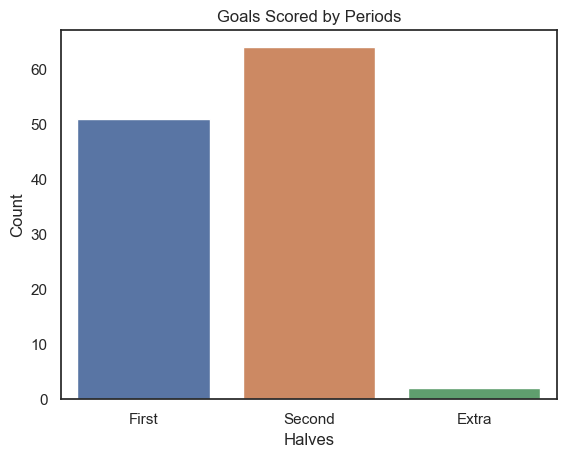

In [162]:
sns.set_theme(style="white")
ax=sns.barplot(x=['First', 'Second', 'Extra'], y=halves.Team)
ax.set_title('Goals Scored by Periods')
ax.set_ylabel('Count')
ax.set_xlabel('Halves');

In [131]:
t=df[['Team','Half']].groupby(['Team','Half']).value_counts().reset_index()

In [136]:
t = t.rename(columns={0:'Count'})

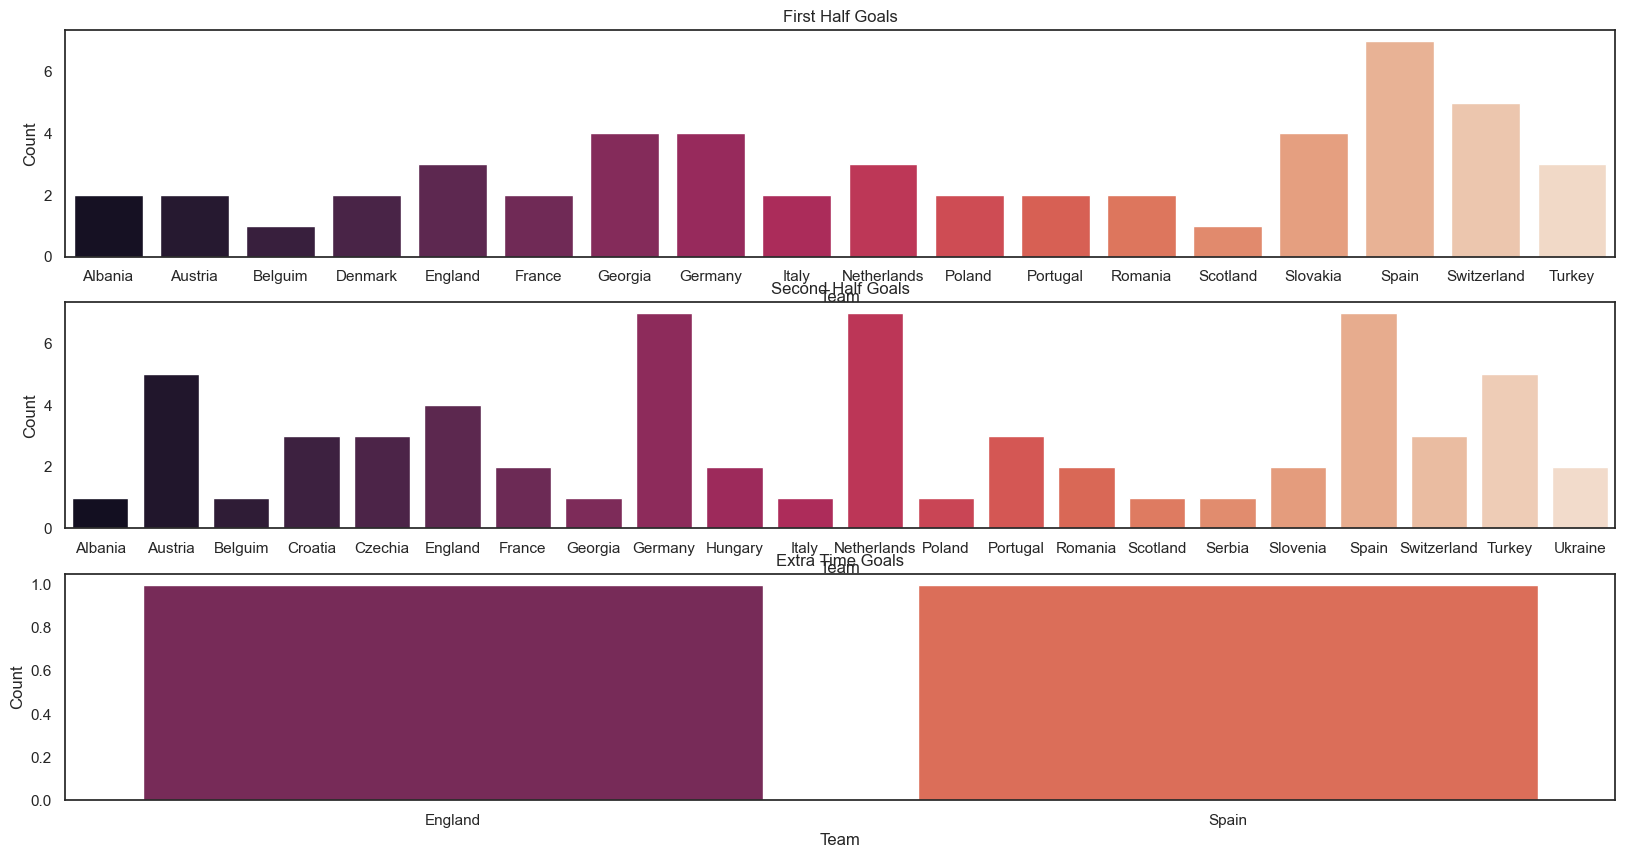

In [166]:
first = t[t['Half']==1]
second = t[t['Half']==2]
extra = t[t['Half']==3]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

sns.barplot(x=first['Team'], y=first['Count'], palette="rocket", ax=ax1)
ax1.set_title('First Half Goals')
ax2.set_title('Second Half Goals')
ax3.set_title('Extra Time Goals')
sns.barplot(x=second['Team'], y=second['Count'], palette="rocket", ax=ax2)
sns.barplot(x=extra['Team'], y=extra['Count'], palette="rocket", ax=ax3);


## Average time after a goal for another goal

I want to find the time it takes a team to score a goal AFTER a goal has been scored. I'll be able to use this info for the average.

In [38]:
for i in range(len(df)):
    if df.loc[i,'Aggregate']==1:
        df.loc[i,'Duration']=0
    else:
        df.loc[i, 'Duration'] = df.loc[i, 'Minute']-df.loc[i-1, 'Minute']

In [44]:
print('The average duration between goals is ', df['Duration'].mean(), ' minutes')

The average duration between goals is  15.025641025641026  minutes


Let's do some graphing! 

In [71]:
#Get all the teams (which are in order of how well they did)
teams = df.Team.unique()

#Create a list of the average duration of time after a goal to score
avg_dur = []
for team in teams:
    avg_dur.append(df[df['Team']==team]['Duration'].mean())

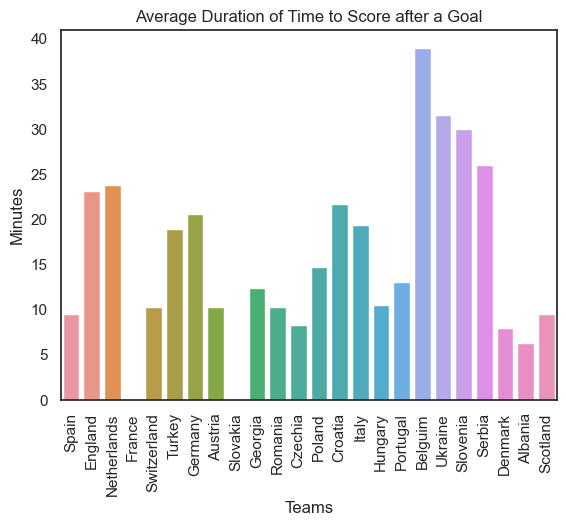

In [89]:
#Plot a bargraph

sns.set_theme(style="white")
ax=sns.barplot(x=teams, y=avg_dur)
ax.set_title('Average Duration of Time to Score after a Goal')
ax.set_ylabel('Minutes')
ax.set_xlabel('Teams')
plt.xticks(rotation=90);

I also want to see the average minute teams scored as well as the total amount of goals scored for each team.

In [74]:
goals_per_team = df['Team'].value_counts()

In [75]:
goals_per_team

Spain          15
Germany        11
Netherlands    10
Switzerland     8
Turkey          8
England         8
Austria         7
Georgia         5
Portugal        5
France          4
Slovakia        4
Romania         4
Italy           3
Albania         3
Poland          3
Croatia         3
Czechia         3
Hungary         2
Belguim         2
Ukraine         2
Slovenia        2
Denmark         2
Scotland        2
Serbia          1
Name: Team, dtype: int64

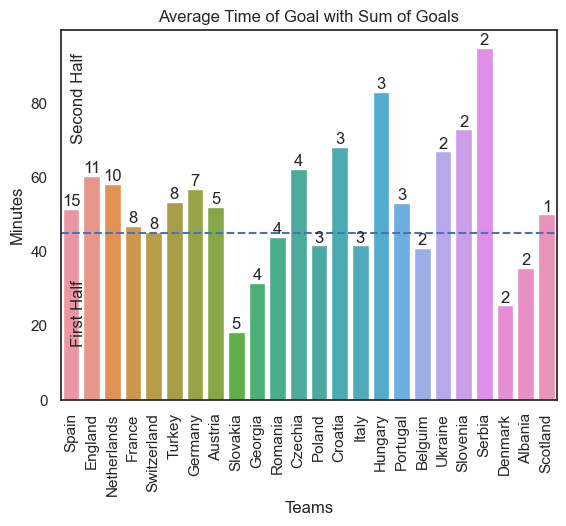

In [90]:
avg_min = []
for team in teams:
    avg_min.append(df[df['Team']==team]['Minute'].mean())

ax=sns.barplot(x=teams, y=avg_min)
ax.set_title('Average Time of Goal with Sum of Goals')
ax.set_ylabel('Minutes')
ax.set_xlabel('Teams')
ax.axhline(y = 45, linestyle = "dashed")
plt.xticks(rotation=90)
ax.text(0, 15, "First Half", rotation=90)
ax.text(0, 70, "Second Half", rotation=90)
ax.bar_label(ax.containers[0], labels=goals_per_team);

Of the teams with an average duration of 0, I want to explore France more. My guess is that they scored first every time. 

I will make a subset of just France and see their Aggregate data is all 1s.

In [69]:
france = df[df['Team']=='France'].copy()
france

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes,Durcation
6,7/9/2024,43,France,1,1,9,0.0,NaN,NaN
23,7/1/2024,37,France,1,2,85,0.0,NaN,NaN
43,6/25/2024,29,France,1,2,56,0.0,Penalty,NaN
94,6/17/2024,8,France,1,1,38,0.0,Own_Goal,NaN


In [68]:
slovakia = df[df['Team']=='Slovakia'].copy()
slovakia

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes,Durcation
24,6/30/2024,36,Slovakia,1,1,25,0.0,NaN,NaN
36,6/26/2024,32,Slovakia,1,1,24,0.0,NaN,NaN
63,6/21/2024,20,Slovakia,1,1,17,0.0,NaN,NaN
93,6/17/2024,9,Slovakia,1,1,7,0.0,NaN,NaN


In [195]:
goal_num = df['Aggregate'].unique()

In [231]:
for goal in goal_num:
    print(goal)

1
2
3
4
5
6


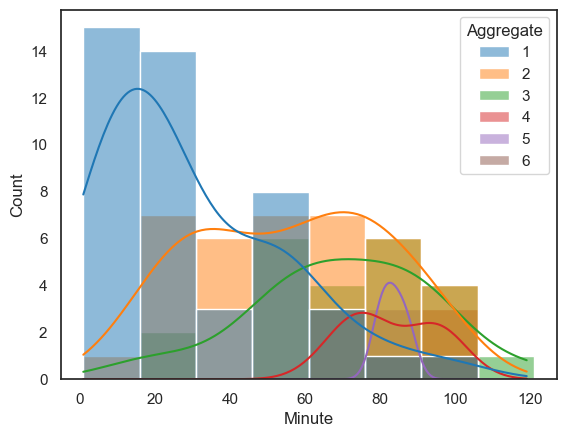

In [194]:
sns.histplot(data=df, x='Minute', kde=True, hue='Aggregate', binwidth=15, palette='tab10')
ax.set_title(' Time of Goals for Each Goal Number');

The mean of Goal Number 1 is 29.844444444444445
The mean of Goal Number 1 is 22.0
The mean of Goal Number 2 is 56.078947368421055
The mean of Goal Number 2 is 58.0
The mean of Goal Number 3 is 69.78260869565217
The mean of Goal Number 3 is 66.0
The mean of Goal Number 4 is 83.0
The mean of Goal Number 4 is 78.0
The mean of Goal Number 5 is 83.33333333333333
The mean of Goal Number 5 is 83.0
The mean of Goal Number 6 is 93.0
The mean of Goal Number 6 is 93.0


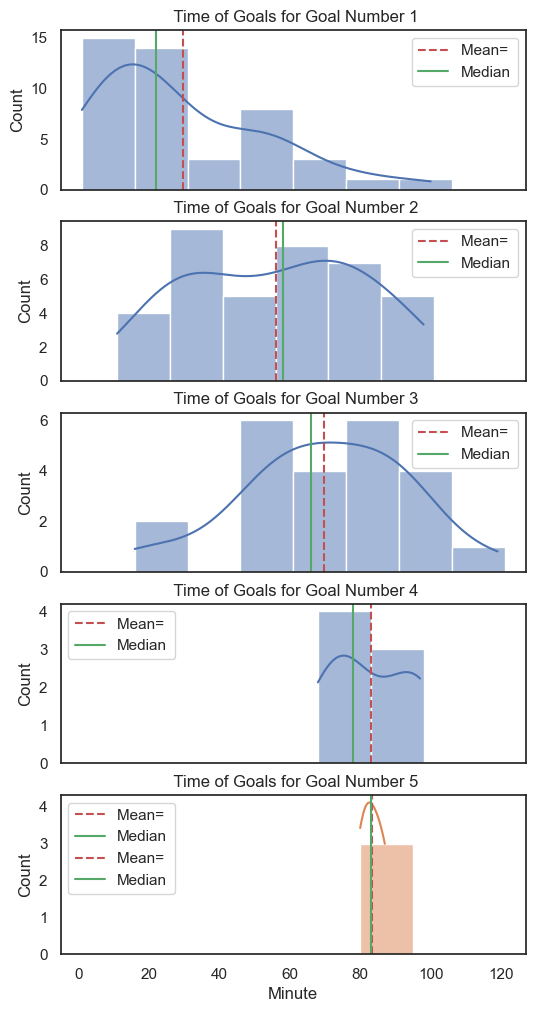

In [229]:
fig, ax = plt.subplots(6, 1, figsize = (6, 12), sharex=True)
for goal in goal_num-1:
    plt.sca(ax[goal-1])
    sns.histplot(data=df[df['Aggregate']==goal+1], x=df[df['Aggregate']==goal]['Minute'], kde=True,  binwidth=15)
    ax[goal-1].set_title(' Time of Goals for Goal Number ' + str(goal))
    ax[goal-1].axvline(df[df['Aggregate']==goal+1]['Minute'].mean(), color='r', linestyle='--', label='Mean= ')
    ax[goal-1].axvline(df[df['Aggregate']==goal+1]['Minute'].median(), color='g', linestyle='-', label="Median")
    ax[goal-1].legend()
    print('The mean of Goal Number {} is {}'.format(goal +1, df[df['Aggregate']==goal+1]['Minute'].mean()))
    print('The mean of Goal Number {} is {}'.format(goal+1, df[df['Aggregate']==goal+1]['Minute'].median()))
    ;

IndexError: index 5 is out of bounds for axis 0 with size 5

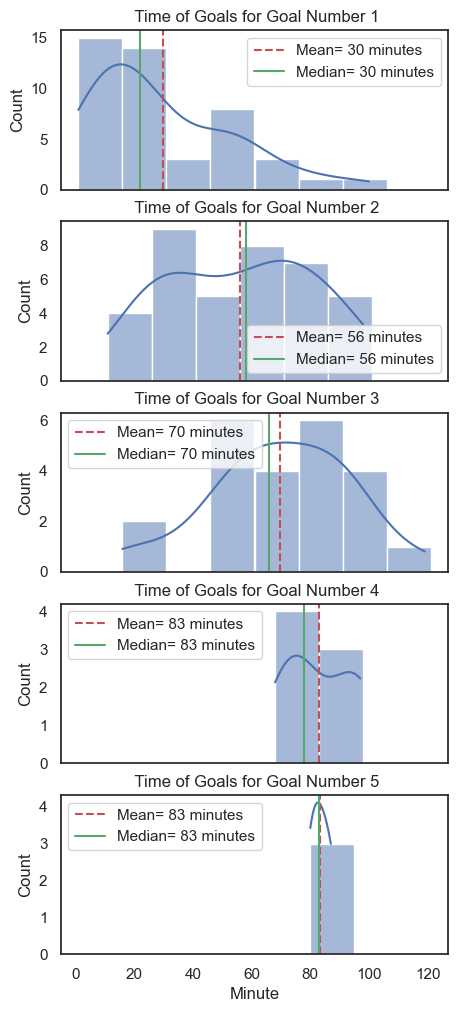

In [250]:
fig, ax = plt.subplots(5, 1, figsize = (5, 12), sharex=True)
for goal in goal_num:
    plt.sca(ax[goal-1])
    sns.histplot(data=df[df['Aggregate']==goal], x=df[df['Aggregate']==goal]['Minute'], kde=True,  binwidth=15)
    ax[goal-1].set_title(' Time of Goals for Goal Number ' + str(goal))
    ax[goal-1].axvline(df[df['Aggregate']==goal]['Minute'].mean(), color='r', linestyle='--', 
                       label='Mean= {} minutes'.format(round(df[df['Aggregate']==goal]['Minute'].mean())))
    ax[goal-1].axvline(df[df['Aggregate']==goal]['Minute'].median(), color='g', linestyle='-', 
                       label='Median= {} minutes'.format(round(df[df['Aggregate']==goal]['Minute'].mean())))
    ax[goal-1].legend()
    ;